In [12]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc
import pymysql as mdb

%matplotlib notebook

# Connecting to MySQL and Retrieving Data

In [13]:
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'abdullah1439', 
                  charset='utf8', use_unicode=True);

db_name = "spotify_songs"
table_name = "english_songs"

In [14]:
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT * FROM {db}.{table}".format(db='spotify_songs', table='english_songs'))
rows = cur.fetchall()
cur.close()

songs_df = pd.DataFrame(list(rows))

In [15]:
#names of the songs
NAMES = list(songs_df["song_name"])

# Clustering

In [16]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
df_cluster = songs_df[cluster_features]
X = np.array(df_cluster)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

<IPython.core.display.Javascript object>


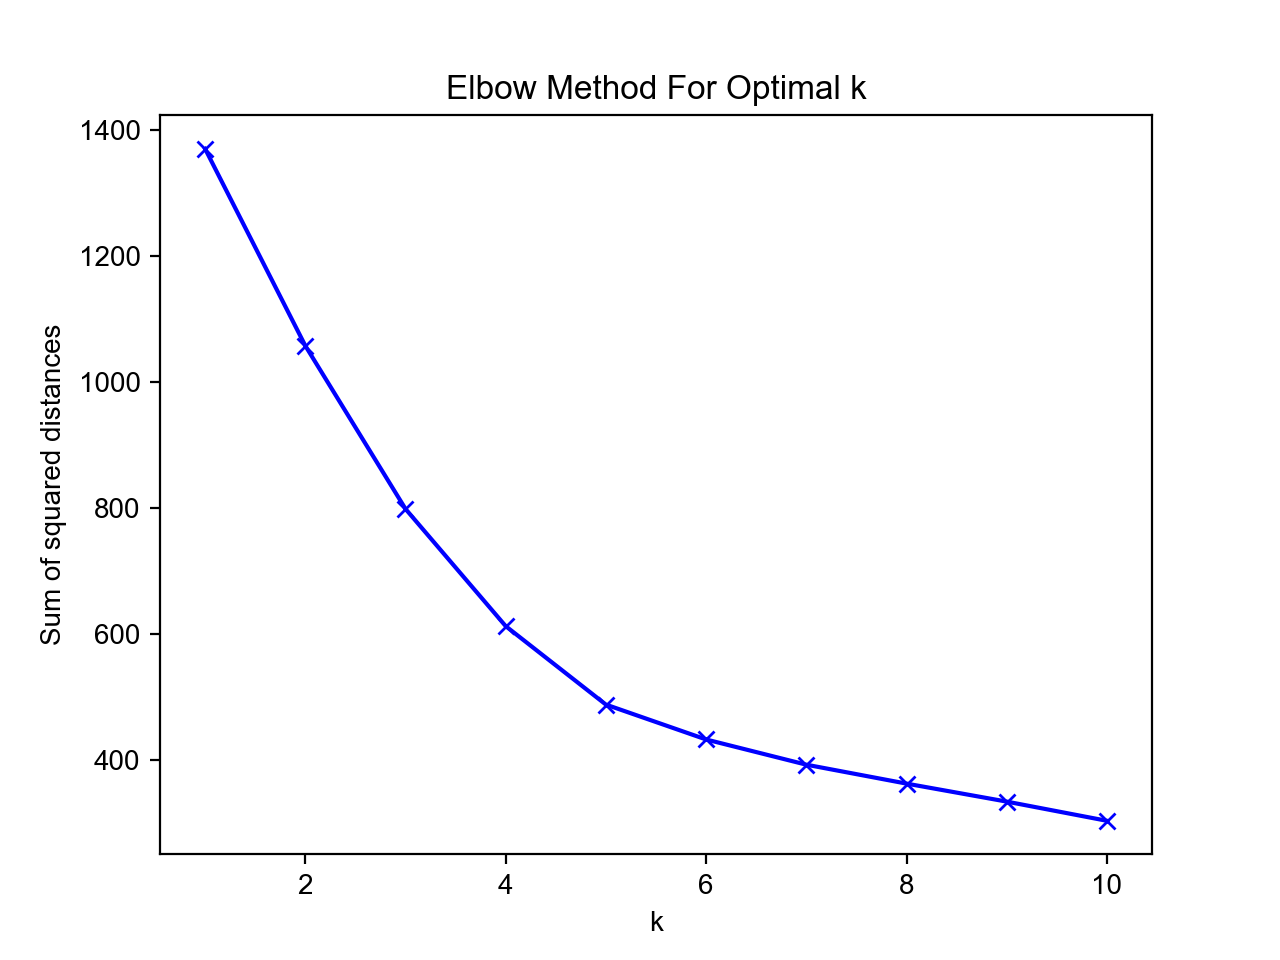

In [17]:
#Elbow method to determine k for k-means clustering

ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km = km.fit(X)
    ss_dist.append(km.inertia_)
plt.figure()
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<IPython.core.display.Javascript object>


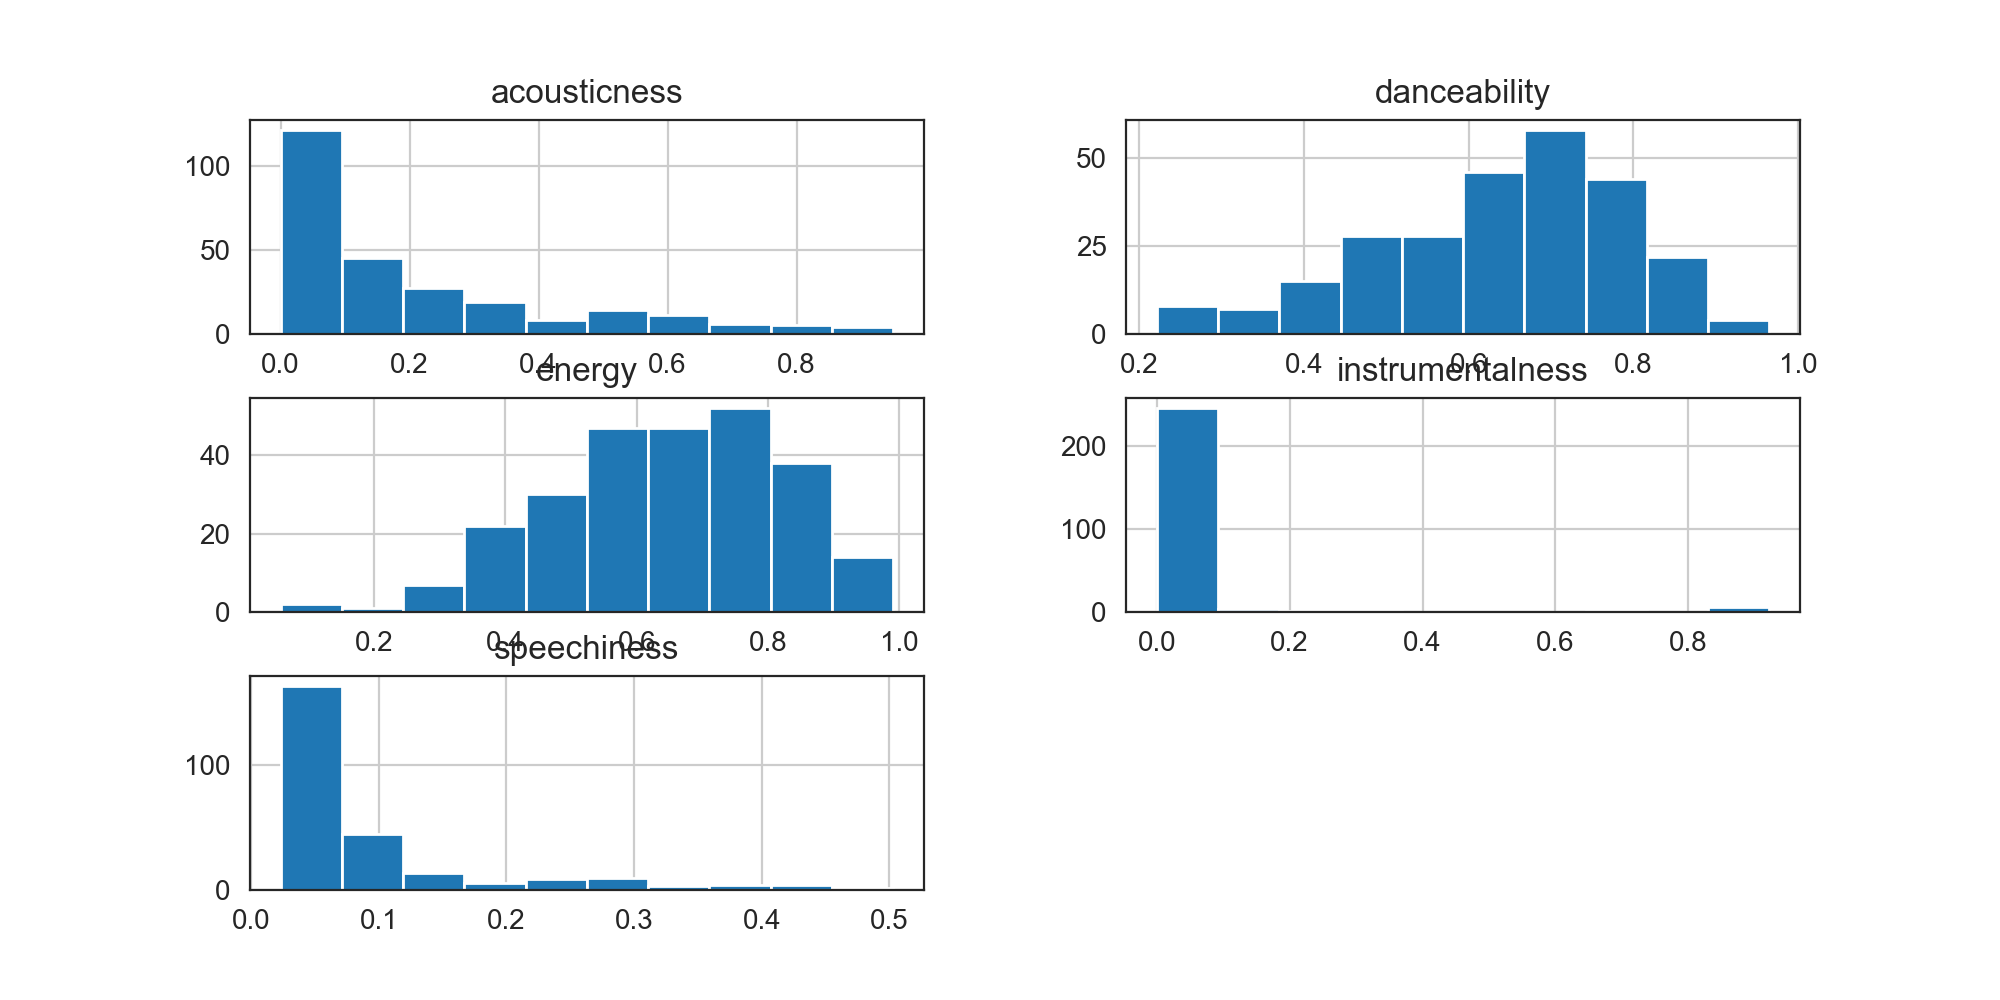

In [106]:
df_cluster.hist(figsize=(10,5))
plt.show()

In [18]:
num_clusters = 5 #elbow method shows an inflection point at 5
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=123).fit(X)

## Visualizing the Cluster - PCA

In [19]:
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(X)

In [20]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.7801924731734856


array([0.33337624, 0.57930472, 0.78019247])

In [21]:
df_pca_vis = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca.explained_variance_ratio_})
df_pca_vis['cum_sum'] = df_pca_vis['Indiv'].cumsum()
df_pca_vis

,Component,Indiv,cum_sum
0,1,0.333376,0.333376
1,2,0.245928,0.579305
2,3,0.200888,0.780192


<IPython.core.display.Javascript object>


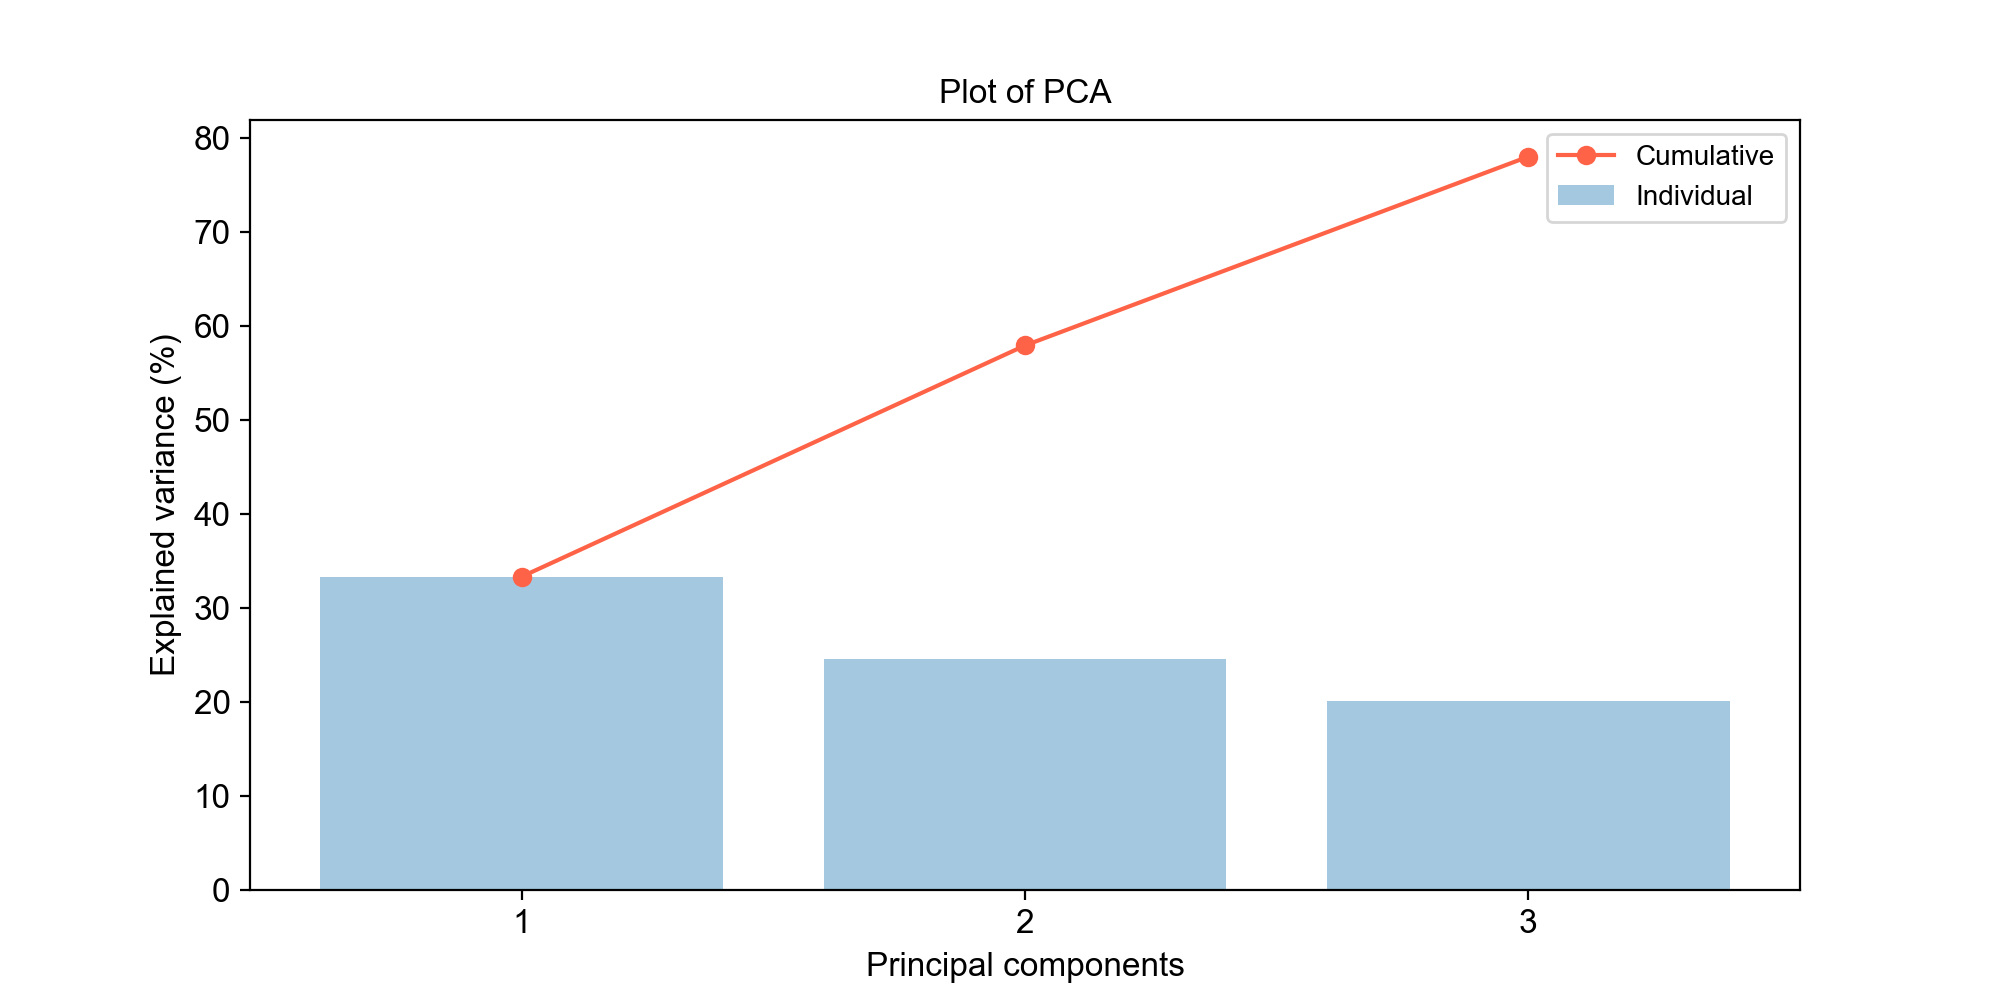

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

In [24]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,0.617232,-1.475546,1.636846,4
1,2.783091,-1.855626,-0.458665,3
2,-0.451806,-0.036408,-0.169453,0
3,-1.321587,-0.675474,-0.236221,0
4,-0.861736,0.295920,-0.438143,2


<IPython.core.display.Javascript object>


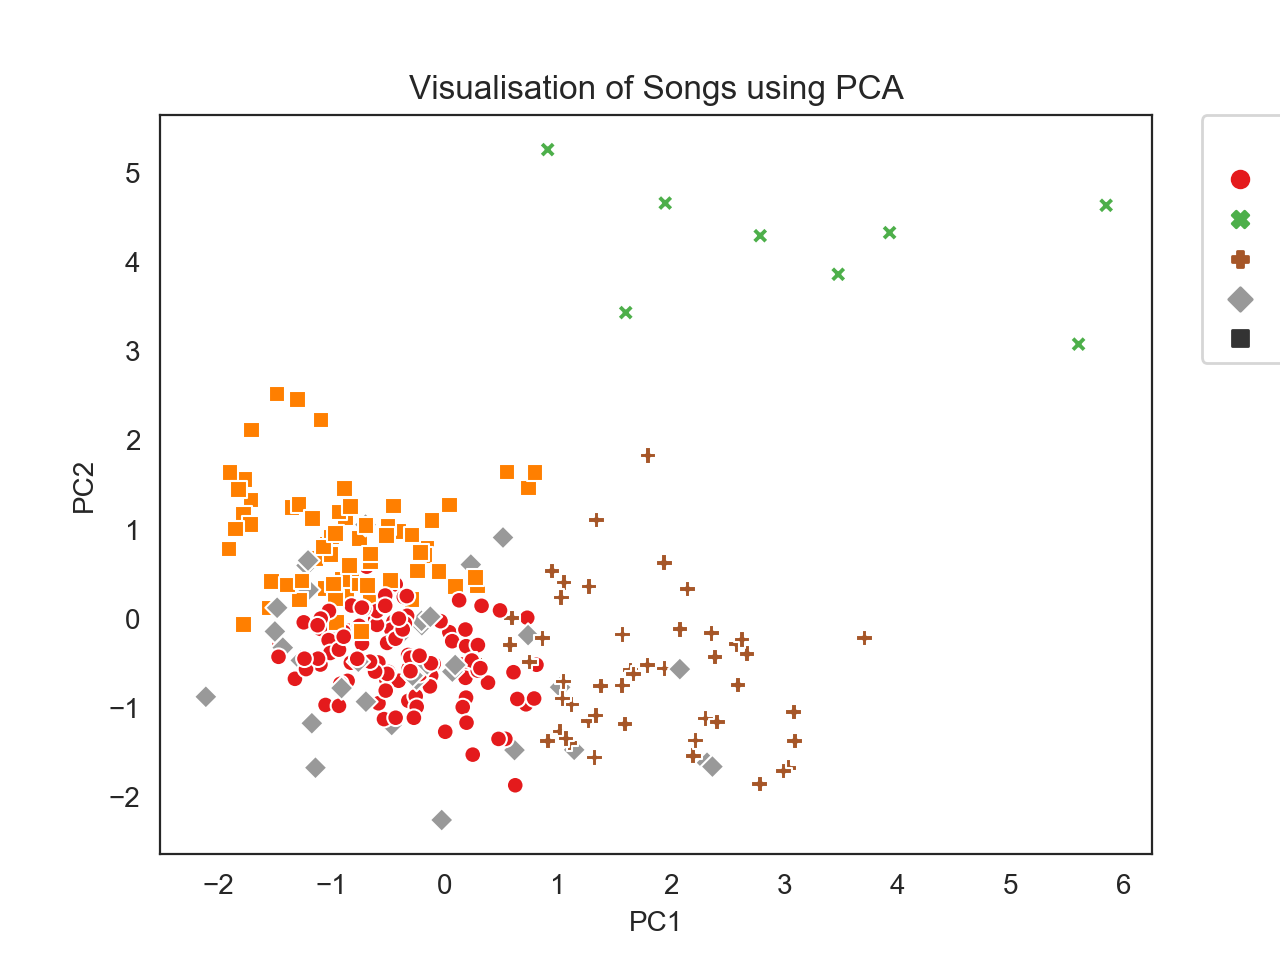

In [25]:
plt.figure()
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

<IPython.core.display.Javascript object>


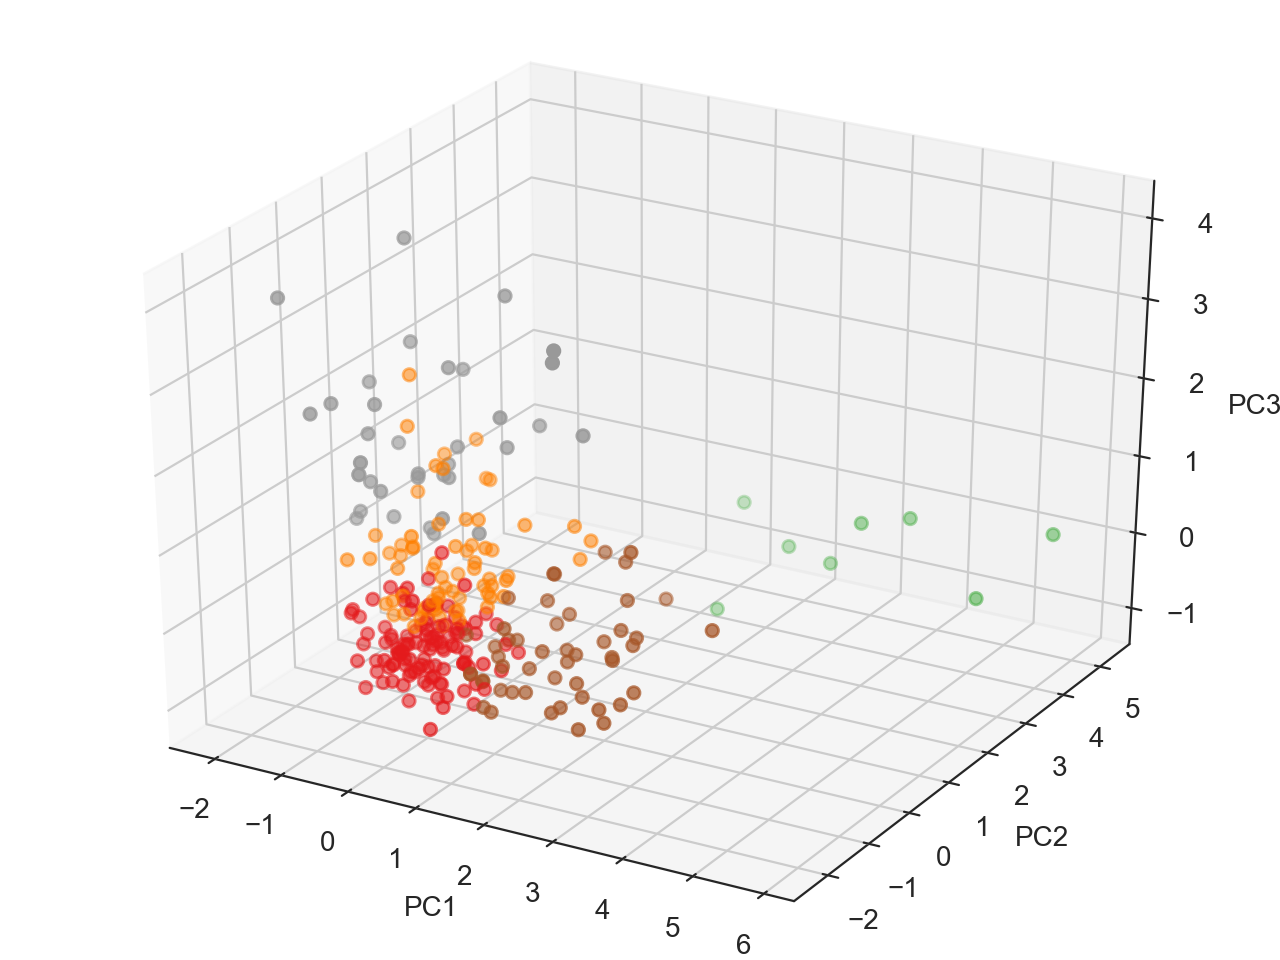

In [27]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

## Visualizing the Cluster - t-SNE

In [28]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=123, learning_rate=190)
tsne_results = tsne.fit_transform(X)

In [29]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,-1.865285,-5.867092,4
1,-8.977742,-2.546874,3
2,4.729230,1.353467,0
3,2.002111,6.713405,0
4,6.762312,4.239666,2


<IPython.core.display.Javascript object>


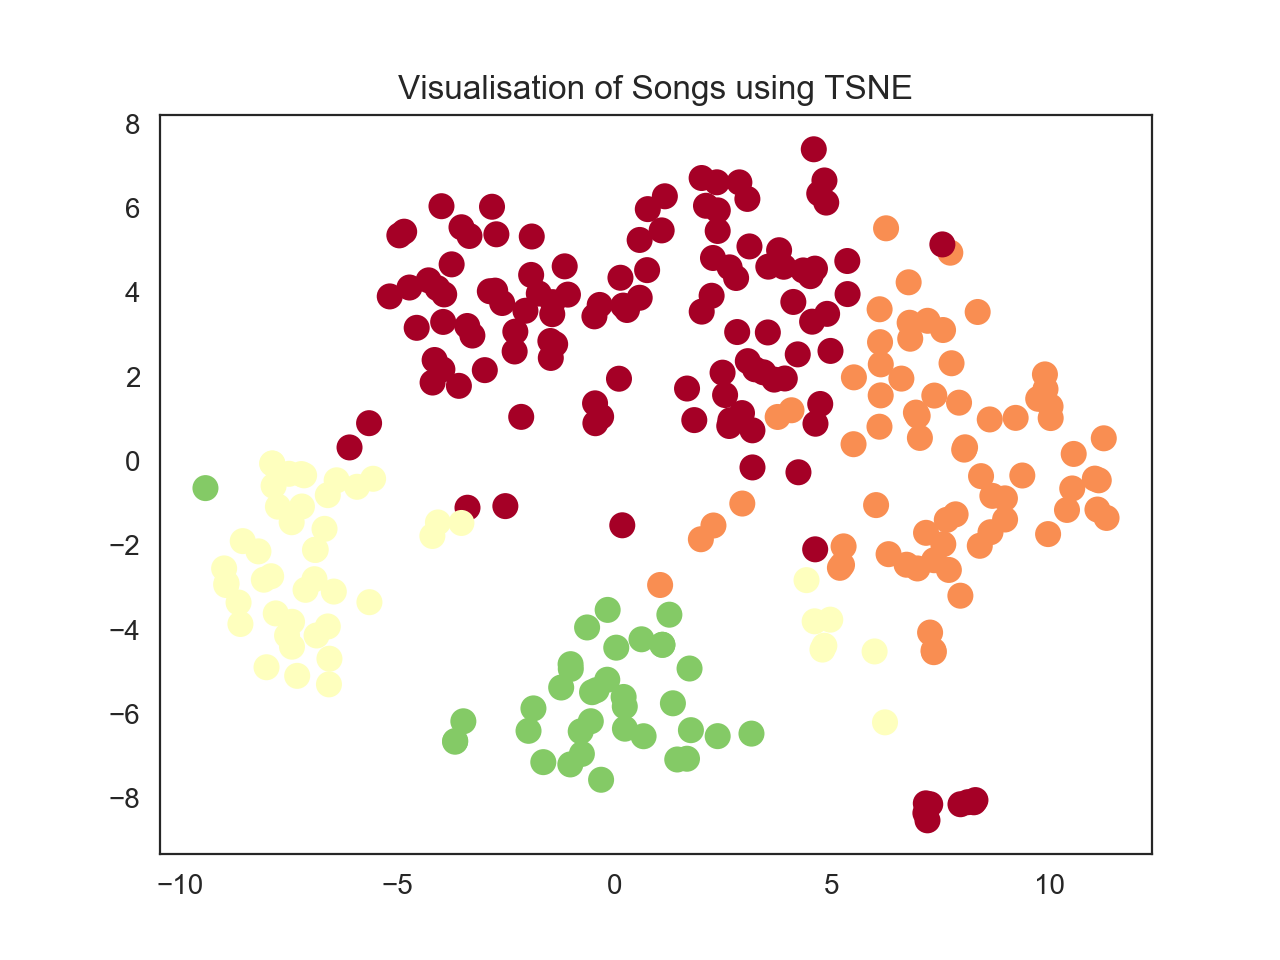

In [30]:
# visualizing the clusters by reducing the dimension of the data through t-SNE
# added the hover effect over the graph so you can see the name of the song for each data point in the graph

c = np.random.randint(1,5,size=len(NAMES))

norm = plt.Normalize(1,5)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(df_tsne['D1'], df_tsne['D2'], c=df_tsne['label'], s=70, cmap=cmap, norm=norm)
plt.title('Visualisation of Songs using TSNE')
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)


def hover(event):
    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([NAMES[n] for n in ind["ind"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
        

fig.canvas.mpl_connect("motion_notify_event", hover)
#plt.gcf().set_size_inches((12, 8)) 
plt.show();

<IPython.core.display.Javascript object>


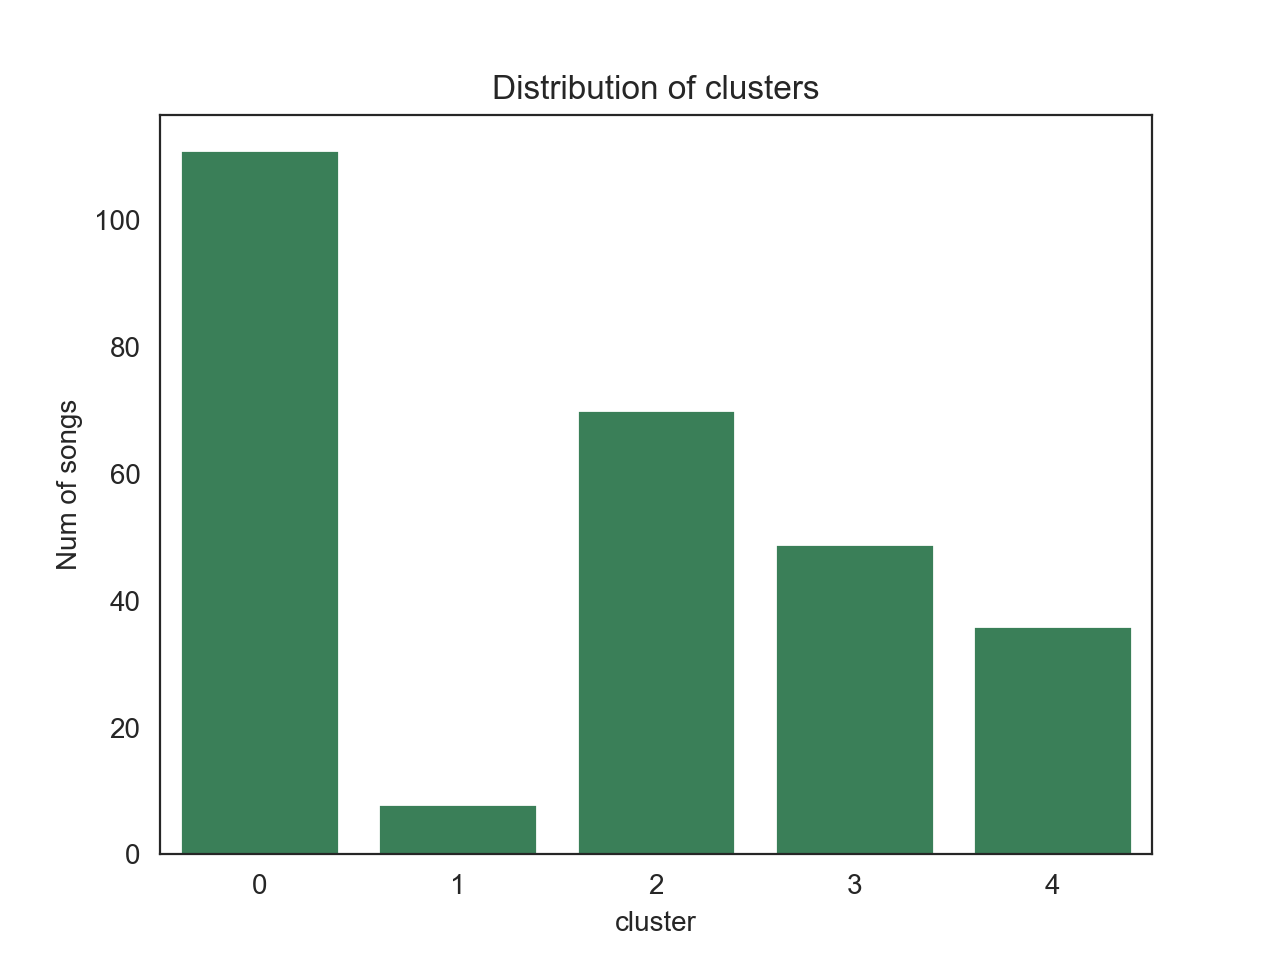

In [35]:
songs_df.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = songs_df.groupby('cluster').size().reset_index(name='Num of songs')
plt.figure()
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show();

<IPython.core.display.Javascript object>


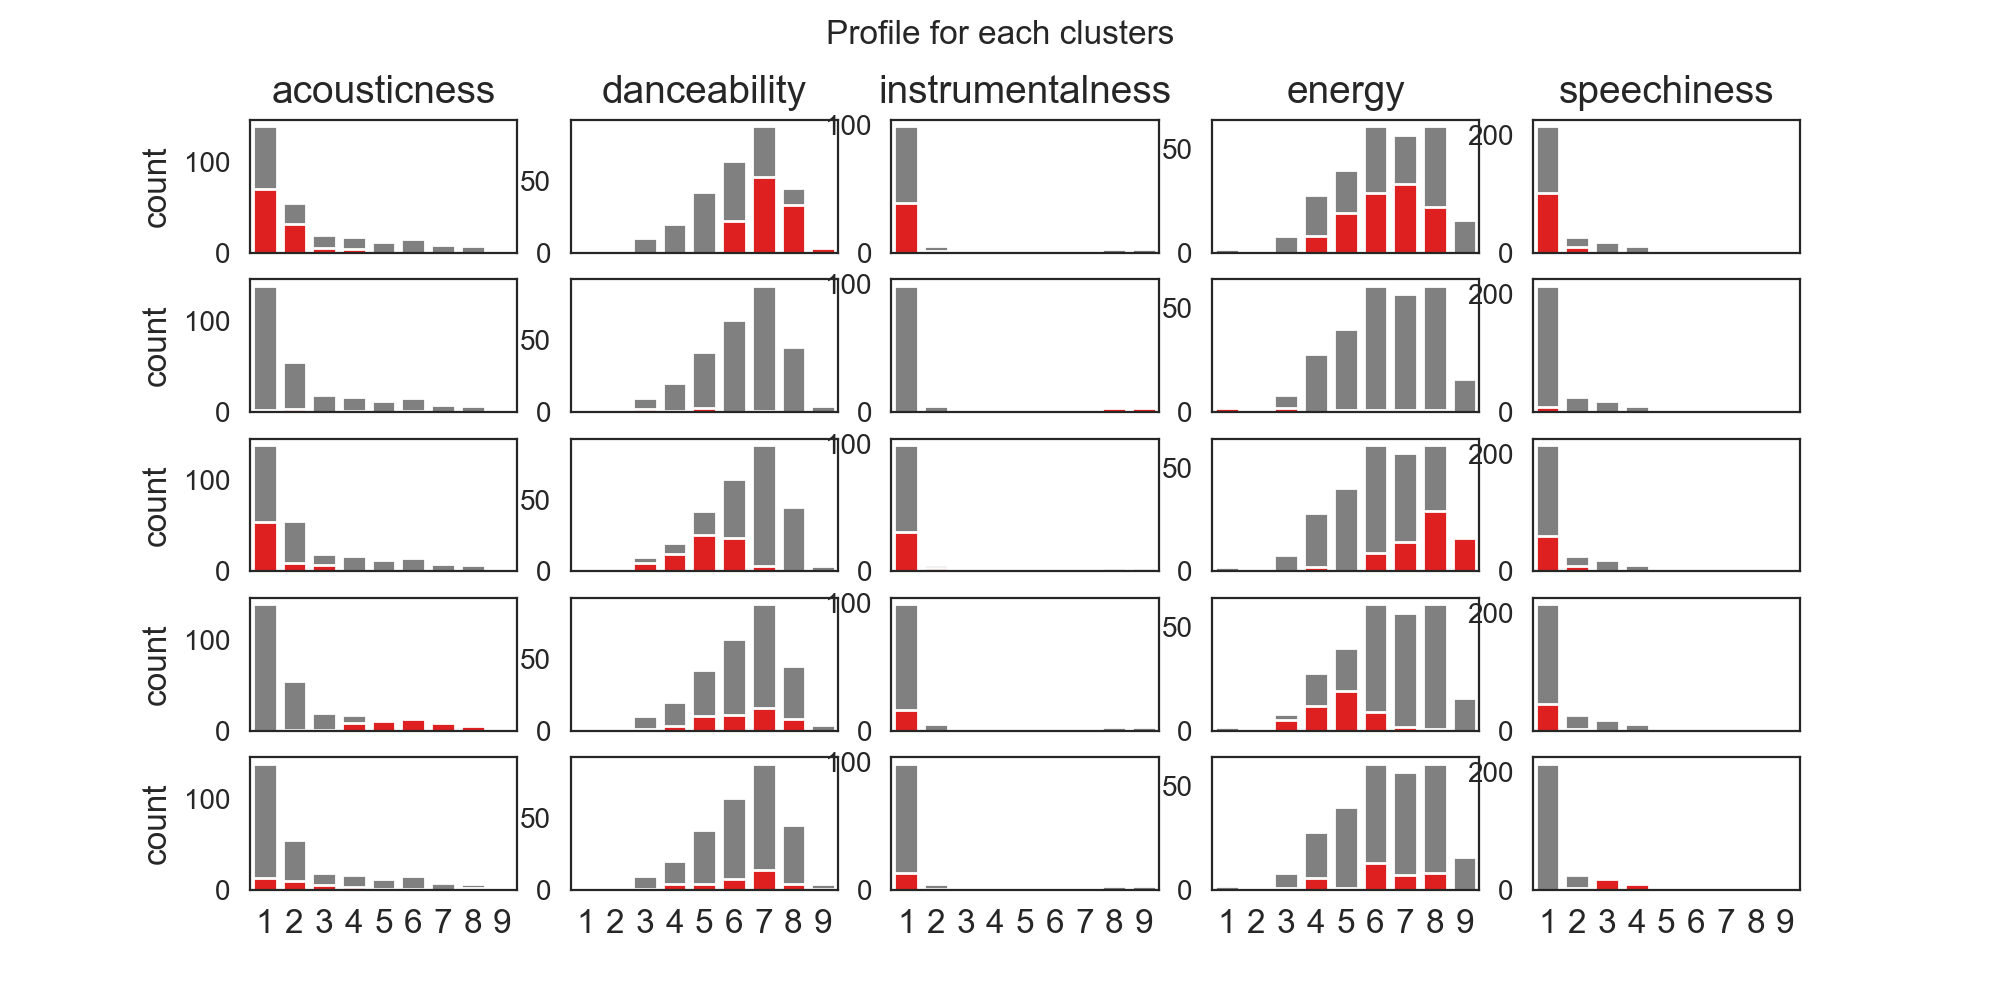

In [36]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(10, 5), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(songs_df['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = songs_df[songs_df['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
#         create binned count for all recent df and clustered df
        rec_grp = songs_df.groupby(pd.cut(songs_df[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In [171]:
X_ = songs_df[['song_name','acousticness', 'danceability', 'energy', 'instrumentalness', 'label',
              'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']]

In [172]:
#quick look at the features

X_.describe()

,acousticness,danceability,energy,instrumentalness,label,liveness,loudness,mode,speechiness,tempo,valence
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.201628,0.639312,0.649048,0.030541,0.811538,0.156416,-6.005962,0.611538,0.095016,118.682412,0.468846
std,0.224729,0.150178,0.176104,0.147297,0.391835,0.114392,2.328121,0.488340,0.095079,27.707808,0.227360
min,0.000007,0.221000,0.057500,0.000000,0.000000,0.024300,-16.996000,0.000000,0.023200,71.556000,0.037100
25%,0.039275,0.533000,0.532250,0.000000,1.000000,0.090000,-6.981750,0.000000,0.039900,99.330750,0.289750
50%,0.109000,0.665500,0.655500,0.000000,1.000000,0.114000,-5.682500,1.000000,0.057150,116.145000,0.468000
75%,0.290250,0.749000,0.785500,0.000018,1.000000,0.180500,-4.640500,1.000000,0.102000,135.028500,0.630500
max,0.950000,0.965000,0.991000,0.922000,1.000000,0.760000,-1.580000,1.000000,0.503000,205.272000,0.969000


In [173]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 12 columns):
song_name           260 non-null object
acousticness        260 non-null float64
danceability        260 non-null float64
energy              260 non-null float64
instrumentalness    260 non-null float64
label               260 non-null int64
liveness            260 non-null float64
loudness            260 non-null float64
mode                260 non-null int64
speechiness         260 non-null float64
tempo               260 non-null float64
valence             260 non-null float64
dtypes: float64(9), int64(2), object(1)
memory usage: 24.5+ KB


<IPython.core.display.Javascript object>


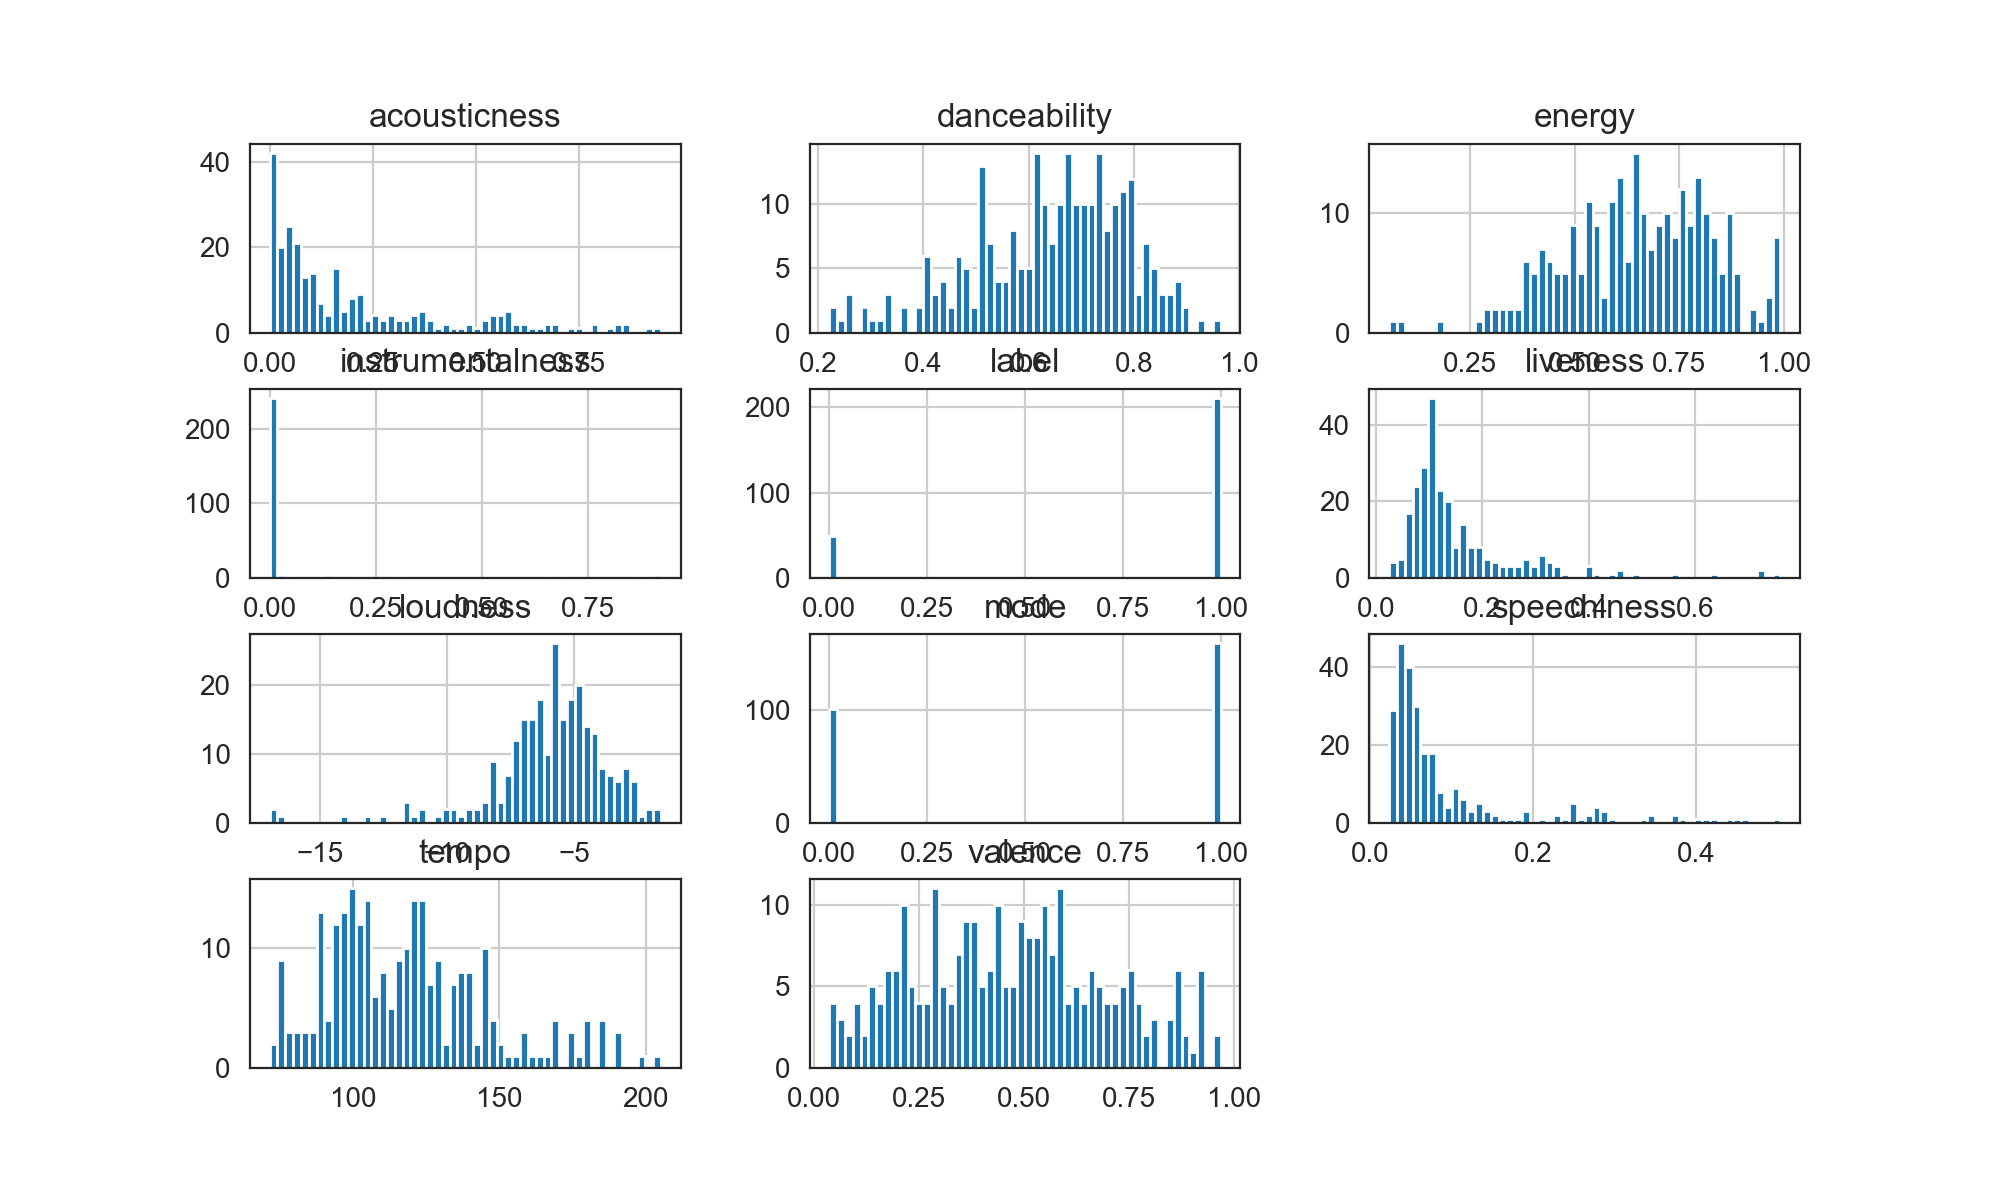

In [159]:
X.hist(bins=50, figsize=(10,6))
plt.show()

Some tail heavy histograms that we may want to transform to make learning efficient. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Disliked', round(X['label'].value_counts()[0]/len(X) * 100,2), '% of the dataset')
print('Liked', round(X['label'].value_counts()[1]/len(X) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


In [165]:
# preparing data for ML algorithms

song_data = train_set.drop(["label", "song_name"], axis=1)
song_labels = train_set["label"].copy()

song_data_test = test_set.drop(["label", "song_name"], axis=1)
song_labels_test = test_set["label"].copy()

In [167]:
# Data Cleaning

# Feature Scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()), 
])

song_data_transformed = num_pipeline.fit_transform(song_data)

In [168]:
from sklearn.linear_model import LogisticRegression

In [170]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(song_data_transformed), len(song_labels)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(song_data_test), len(song_labels_test)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
for train, test in sss.split(song_data_transformed, song_labels):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(song_data_transformed[train], song_labels[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(song_data_transformed[test])
    
    accuracy_lst.append(pipeline.score(song_data_transformed[test], song_labels[test]))
    precision_lst.append(precision_score(song_labels[test], prediction))
    recall_lst.append(recall_score(song_labels[test], prediction))
    f1_lst.append(f1_score(song_labels[test], prediction))
    auc_lst.append(roc_auc_score(song_labels[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 208 | Length of y (train): 208
Length of X (test): 52 | Length of y (test): 52


NameError: name 'sss' is not defined

In [149]:
# Data Cleaning

# Feature Scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()), 
])

song_data_transformed = num_pipeline.fit_transform(song_data)